In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import librosa

# Dataset class definition
class TinySOLDataset(Sequence):
    def __init__(self, csv_file, audio_dir, batch_size=32, n_mels=128, shuffle=True):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations.drop(2912)
        print(self.annotations.columns)
        self.audio_dir = audio_dir
        self.batch_size = batch_size
        self.n_mels = n_mels
        self.shuffle = shuffle
        self.le = LabelEncoder()
        self.annotations['label'] = self.le.fit_transform(self.annotations['Instrument (in full)'])
        self.indices = np.arange(len(self.annotations))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.annotations) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_samples = [self.annotations.iloc[i] for i in batch_indices]
        X, y = self.__data_generation(batch_samples)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_samples):
        X = np.empty((self.batch_size, 128, 128, 1))
        y = np.empty((self.batch_size), dtype=int)
        
        for i, sample in enumerate(batch_samples):
            audio_path = sample['Path']
            mel_spec = extract_mel_spectrogram(audio_path, self.n_mels)
            mel_spec = mel_spec.T[:128, :128]  # Resize to 128x128 if necessary
            if mel_spec.shape != (128, 128):
                mel_spec = np.pad(mel_spec, ((0, max(0, 128 - mel_spec.shape[0])), (0, max(0, 128 - mel_spec.shape[1]))), mode='constant')
            mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()  # Normalize
            X[i,] = np.expand_dims(mel_spec, axis=-1)
            y[i] = sample['label']
        
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.le.classes_))

def extract_mel_spectrogram(file_path, n_mels=128):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Create and compile model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Paths to dataset
csv_file = 'D:\\git desk\\Voice-Morph-Companion\\Week 3\\Audio and CNN Assignment\\TInySOL Dataset\\TinySOL\\TinySOL_metadata (1).csv'
audio_dir = 'D:\\git desk\\Voice-Morph-Companion\\Week 3\\Audio and CNN Assignment\\TInySOL Dataset'

# Initialize dataset and model
dataset = TinySOLDataset(csv_file, audio_dir)
input_shape = (128, 128, 1)
num_classes = len(dataset.le.classes_)

# Create and compile the model
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(dataset, epochs=20, callbacks=[lr_scheduler])


Index(['Path', 'Fold', 'Family', 'Instrument (abbr.)', 'Instrument (in full)',
       'Technique (abbr.)', 'Technique (in full)', 'Pitch', 'Pitch ID',
       'Dynamics', 'Dynamics ID', 'Instance ID', 'String ID (if applicable)',
       'Needed digital retuning'],
      dtype='object')


c:\Users\ridhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


c:\Users\ridhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3330 - loss: 7.3365 - learning_rate: 0.0010
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 856ms/step - accuracy: 0.6063 - loss: 1.2238 - learning_rate: 0.0010
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 86s 910ms/step - accuracy: 0.7049 - loss: 0.8638 - learning_rate: 0.0010
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 88s 930ms/step - accuracy: 0.8138 - loss: 0.5443 - learning_rate: 0.0010
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8240 - loss: 0.5128 - learning_rate: 0.0010
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1795s 20s/step - accuracy: 0.8168 - loss: 0.5894 - learning_rate: 0.0010
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8718 - loss: 0.3788 - learning_rate: 0.0010
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8856 - loss: 0.3429 - learning_rate: 0.0010
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8850 - loss: 0.3865 - learning_rate: 0.0010
Epoch 10/20
91/91 ━━━━

In [9]:
all_predictions = []

# Predict for complete batches
for index in range(len(dataset)):
    batch_X, _ = dataset[index]
    batch_predictions =model.predict(batch_X)
    all_predictions.extend(np.argmax(batch_predictions, axis=1))

# Decode predicted labels to their original class names
pseudo_labels = dataset.le.inverse_transform(all_predictions)

# Add the pseudo_labels to the annotations DataFrame
#dataset.annotations['pseudo_label'] = pseudo_labels

# Decode predicted labels to their original class names


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━

In [10]:

#dataset.annotations['pseudo_label'] = pseudo_labels
dataset.annotations['label']=all_predictions

In [11]:
#model = create_model(input_shape, num_classes)

# Compile and train model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(dataset, epochs=10)
model_with_pseudo_labels = create_model(input_shape, num_classes)
model_with_pseudo_labels.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_pseudo_labels = model_with_pseudo_labels.fit(dataset, epochs=10)

c:\Users\ridhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 73s 737ms/step - accuracy: 0.1465 - loss: 7.8959
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 78s 821ms/step - accuracy: 0.2261 - loss: 2.6226
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 84s 878ms/step - accuracy: 0.2486 - loss: 2.5712
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.2395 - loss: 2.5466
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 79s 823ms/step - accuracy: 0.2340 - loss: 2.5220
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 836ms/step - accuracy: 0.2371 - loss: 2.5086
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.2378 - loss: 2.4879
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 86s 888ms/step - accuracy: 0.2432 - loss: 2.4745
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 79s 832ms/step - accuracy: 0.2204 - loss: 2.4798
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 838ms/step - accuracy: 0.2380 - loss: 2.4571


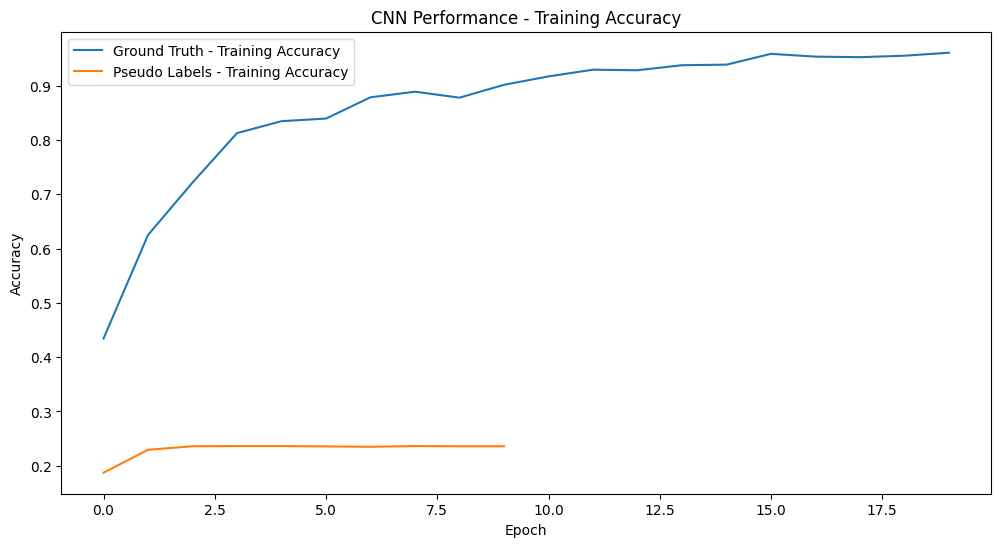

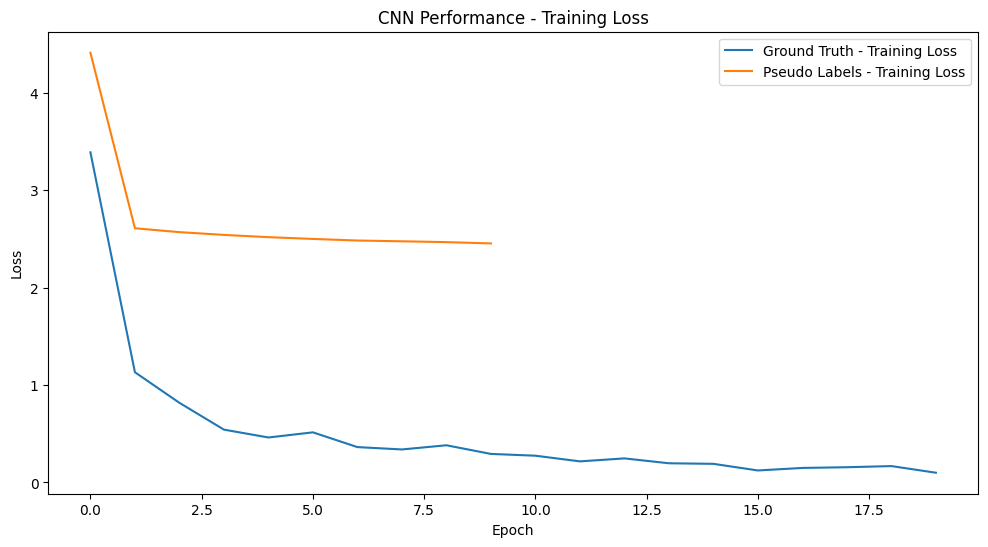

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Ground Truth - Training Accuracy')

plt.plot(history_pseudo_labels.history['accuracy'], label='Pseudo Labels - Training Accuracy')

plt.title('CNN Performance - Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Ground Truth - Training Loss')

plt.plot(history_pseudo_labels.history['loss'], label='Pseudo Labels - Training Loss')

plt.title('CNN Performance - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()